In [19]:
%matplotlib inline
import os
import yaml

import numpy as np
import esmlab

import xarray as xr

import ncar_jobqueue
from dask.distributed import Client

import utils
import climo_utils as cu
import ann_avg_utils as aau
units, _ = aau.get_pint_units()

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

import cartopy
import cartopy.crs as ccrs
import cmocean

import xpersist as xp
# Set up xperist cache
cache_dir = os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects', 'cesm2-marbl', 'xpersist_cache', '3d_fields')
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy         1.18.1
esmlab        2019.4.27
xarray        0.15.0
cmocean       2.0
yaml          5.2
cartopy       0.17.0
xpersist      0.0.post25
ncar_jobqueue 2020.1.15
Mike Levy 2020-03-05 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper05
Git hash   : dd7eee278020face8c8aabce3eef5af86a8880d6


In [20]:
cluster = ncar_jobqueue.NCARCluster() #project='P93300606')
cluster.adapt(minimum_jobs=0, maximum_jobs=24)
client = Client(cluster)
client

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.205.14:34741 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/40237/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [21]:
nutrients = ['NO3', 'PO4', 'SiO3']
three_ocean_regions = True

In [22]:
%%time

da_surf = dict()
ds = dict()
da_surf_obs = dict()
ds_obs = dict()

for variable in nutrients:
    # Read CESM and WOA data
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}', trust_cache=True)
    ds[variable] = xp_func(slice("1990-01-15", "2015-01-15"), variable, mean_dims=['member_id', 'time']) # 1990 - 2014, inclusive
    ds_obs[variable] = cu.read_obs(src='WOA', variable=variable)

    da_tmp = ds[variable][variable]
    da_surf[variable] = (da_tmp.isel(z_t=0).data * units[ds[variable][variable].attrs['units']])
    da_tmp = ds_obs[variable][variable]
    da_surf_obs[variable]=da_tmp.isel(z_t=0).data * units[da_tmp.attrs['units']] * (1026*units['kg/m^3'])

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/NO3.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/PO4.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/SiO3.nc
CPU times: user 58.4 ms, sys: 14.8 ms, total: 73.3 ms
Wall time: 481 ms


In [23]:
%%time
kwargs = {'grid' : 'gx1v7'}
if three_ocean_regions:
    kwargs['rmask_file'] = os.path.join(os.path.sep,
                                        'glade',
                                        'p',
                                        'cgd',
                                        'oce',
                                        'people',
                                        'klindsay',
                                        'oldcgdoce',
                                        'REGION_MASK',
                                        'new_REGION_MASK_gx1v6.nc')

da_zonal_mean = dict()
da_zonal_mean_obs = dict()
for var in nutrients:
    ds_tmp = utils.zonal_mean_via_fortran(ds[var], var, **kwargs)
    da_zonal_mean[var] = ds_tmp[var]
    ds_tmp = utils.zonal_mean_via_fortran(ds_obs[var], var, **kwargs)
    da_zonal_mean_obs[var] = ds_tmp[var]

za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
CPU times: user 529 ms, sys: 374 ms, total: 903 ms
Wall time: 2.95 s


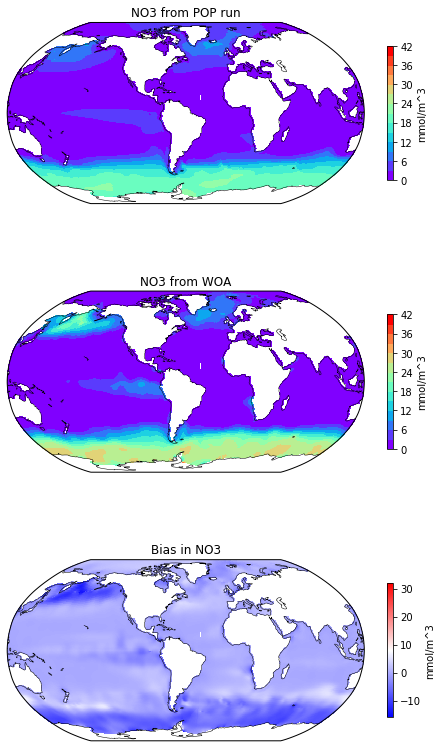

In [24]:
cu.plot_surface_vals('NO3', ds, da_surf, da_surf_obs, obs_src='WOA', force_units='mmol/m^3')

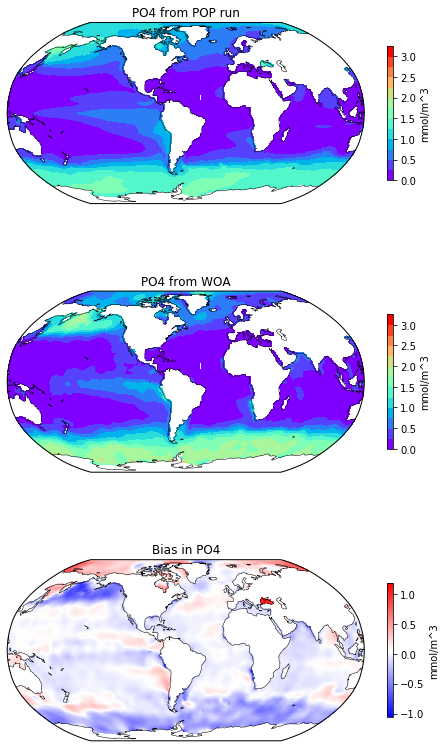

In [25]:
cu.plot_surface_vals('PO4', ds, da_surf, da_surf_obs, obs_src='WOA', force_units='mmol/m^3')

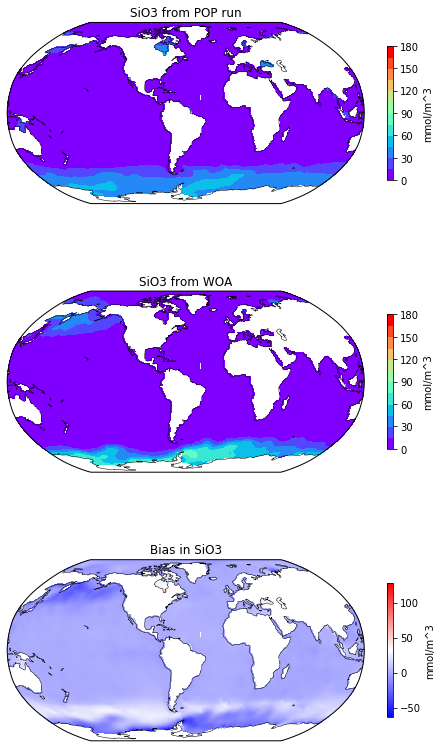

In [26]:
cu.plot_surface_vals('SiO3', ds, da_surf, da_surf_obs, obs_src='WOA', force_units='mmol/m^3')

In [27]:
force_units = 'mmol/m^3'
force_units_pretty = 'mmol m$^{-3}$'

ds_surf_plot = xr.Dataset(
    {'TLONG': ds['NO3'].TLONG, 'TLAT': ds['NO3'].TLAT,}
)

for i, nut in enumerate(['NO3', 'PO4', 'SiO3']):
    simulated = da_surf[nut].to(force_units).magnitude
    observed = da_surf_obs[nut].to(force_units).magnitude

    ds_surf_plot[nut] = xr.DataArray(
        simulated, dims=('nlat', 'nlon'), 
        attrs={'units': force_units_pretty, 'long_name': nut}
    )

    ds_surf_plot[f'{nut}_obs'] = xr.DataArray(
            observed, dims=('nlat', 'nlon'), 
            attrs={'units': force_units_pretty, 'long_name': nut}
        )    

ds_surf_plot = utils.pop_add_cyclic(ds_surf_plot)
ds_surf_plot

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
    TLONG     (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.29 -39.57 -39.86
    NO3       (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    NO3_obs   (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    PO4       (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    PO4_obs   (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SiO3      (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SiO3_obs  (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [28]:
levels = dict(
    NO3=[0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.5, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30,],
    PO4=[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42, 0.46, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0001, 1.2, 1.4, 1.6, 1.8,],
    SiO3=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90,]
)

contour_spec = dict(
    NO3=dict(
        levels=levels['NO3'],
        extend='max',
        cmap=cmocean.cm.haline,
        norm=colors.BoundaryNorm(levels['NO3'], ncolors=cmocean.cm.haline.N),
    ),
    NO3_bias=dict(
        levels=np.arange(-20, 21, 1),
        extend='both',        
        cmap=cmocean.cm.curl,
        norm=colors.DivergingNorm(vmin=-20, vcenter=0., vmax=20),        
    ),
    PO4=dict(
        levels=levels['PO4'],
        extend='max',
        cmap=cmocean.cm.haline,
        norm=colors.BoundaryNorm(levels['PO4'], ncolors=cmocean.cm.haline.N),        
    ),
    PO4_bias=dict(
        levels=np.arange(-2, 2.1, 0.1),
        extend='both',
        cmap=cmocean.cm.curl,   
        norm=colors.DivergingNorm(vmin=-2, vcenter=0., vmax=2),                
    ),
    SiO3=dict(
        levels=levels['SiO3'],
        extend='max',
        cmap=cmocean.cm.haline,
        norm=colors.BoundaryNorm(levels['SiO3'], ncolors=256),        
    ),
    SiO3_bias=dict(
        levels=np.arange(-50, 52, 2),
        extend='both',
        cmap=cmocean.cm.curl,   
        norm=colors.DivergingNorm(vmin=-50, vcenter=0., vmax=50),                
    ),    
    
)

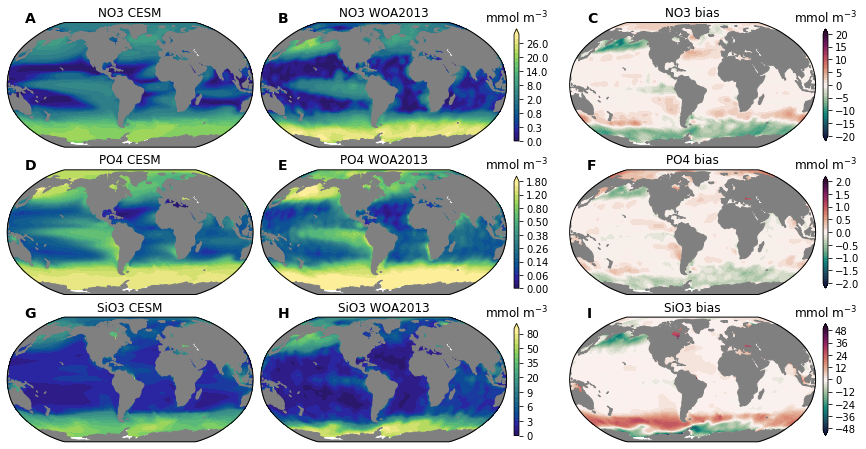

In [30]:
import importlib
importlib.reload(utils)

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1, 1, 0.02, 1, 0.02))

prj = ccrs.Robinson(central_longitude=305.0)

axs = []
maps = []
for i, nut in enumerate(['NO3', 'PO4', 'SiO3']):
    ax_m = plt.subplot(gs[i, 0], projection=prj)
    ax_o = plt.subplot(gs[i, 1], projection=prj)
    ax_b = plt.subplot(gs[i, 3], projection=prj)
    
    cax_field = plt.subplot(gs[i, 2])
    cax_bias = plt.subplot(gs[i, 4])
    
    axs.append((ax_m, ax_o, cax_field, ax_b, cax_bias))
    maps.extend([ax_m, ax_o, ax_b])
    
    cesm = ds_surf_plot[nut]
    obs = ds_surf_plot[f'{nut}_obs']
    bias = cesm - obs

    units = ds_surf_plot[nut].units
    
    
    cf_m = ax_m.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, cesm, 
        **contour_spec[nut],        
        transform=ccrs.PlateCarree(),
    )
    
    cf_o = ax_o.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, obs, 
        **contour_spec[nut],        
        transform=ccrs.PlateCarree(),        
    )
    
    cf_b = ax_b.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, bias, 
        **contour_spec[f'{nut}_bias'],                     
        transform=ccrs.PlateCarree(),        
    )    

    for ax in [ax_m, ax_o, ax_b]:
        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )        
        
    ax_m.set_title(f'{nut} CESM')
    ax_o.set_title(f'{nut} WOA2013')    
    ax_b.set_title(f'{nut} bias')        
    
    cb_field = plt.colorbar(cf_o, cax=cax_field)
    cb_field.ax.set_title(units)
    
    cb_bias = plt.colorbar(cf_b, cax=cax_bias)
    cb_bias.ax.set_title(units)
    
    
    
# add a gap between left two columns and right; scale colorbars
gs.update(left=0.05, right=0.95, hspace=0.05, wspace=0.05)
offset = 0.05
cax_vert_shrink = 0.8
for i in range(len(axs)):
    
    # the row of axis objects
    ax_m, ax_o, cax_field, ax_b, cax_bias = axs[i]
    
    # shift map
    p0 = ax_b.get_position()
    ax_b.set_position([p0.x0 + offset, p0.y0, p0.width, p0.height])

    # shift and scale colorbar
    p0 = cax_bias.get_position()
    shift_up = p0.height * (1. - cax_vert_shrink) / 2
    cax_bias.set_position([p0.x0 + offset, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])

    # scale colorbar    
    p0 = cax_field.get_position()
    shift_up = p0.height * (1. - cax_vert_shrink) / 2
    cax_field.set_position([p0.x0, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])

utils.label_plots(fig, maps, xoff=0.02, yoff=0)   

utils.savefig('nutrients-surface-maps.pdf')

## Compute global profile

Here we use `esmlab` to average over lat / lon, but leave depth

In [37]:
%%time

glb_avg = dict()
glb_avg_obs = dict()

for variable in nutrients:
    print(f'Computing weighted mean of {variable} for CESM output...')
    da_tmp = esmlab.weighted_mean(ds[variable][variable], weights=ds[variable].TAREA, dim=['nlat', 'nlon']).compute()
    glb_avg[variable] = (da_tmp.data * units[ds[variable][variable].attrs['units']])

    print(f'Computing weighted mean of {variable} for WOA data...')
    da_tmp = esmlab.weighted_mean(ds_obs[variable][variable], weights=ds_obs[variable].TAREA, dim=['nlat', 'nlon']).compute()
    glb_avg_obs[variable] = ((da_tmp.data * units[ds_obs[variable][variable].attrs['units']]) * (1026*units['kg/m^3'])).to('mmol/m^3')


Computing weighted mean of NO3 for CESM output...
ere


TypeError: string indices must be integers

In [ ]:
cu.plot_global_profile(nutrients, units, ds, glb_avg, glb_avg_obs)

## Regional Plots

Regions based on code in POP repository:

```
$ cat input_templates/gx1v7_region_ids
   1  'Southern Ocean    '        0.0   0.0      0.0
   2  'Pacific Ocean     '        0.0   0.0      0.0
   3  'Indian Ocean      '        0.0   0.0      0.0
   4  'Persian Gulf      '       22.0  60.0      0.0
  -5  'Red Sea           '       14.0  47.0      3.0e15
   6  'Atlantic Ocean    '        0.0   0.0      0.0
   7  'Mediterranean Sea '       36.0 354.0      0.0
   8  'Labrador Sea      '        0.0   0.0      0.0
   9  'GIN Sea           '        0.0   0.0      0.0
  10  'Arctic Ocean      '        0.0   0.0      0.0
  11  'Hudson Bay        '       61.0 295.0      0.0
 -12  'Baltic Sea        '       56.0   8.0      3.0e15
 -13  'Black Sea         '       40.0  25.0      3.0e15
```

Unless running with `three_ocean_regions = True`, in which case the regions are

```
   1  'Pacific Ocean'
   2  'Indian Ocean'
   3  'Atlantic Ocean'
```

(Not documented anywhere handed, but seen in `/glade/p/cgd/oce/people/klindsay/oldcgdoce/REGION_MASK/new_rmask.m`

```
REGION_MASK(find(REGION_MASK == 2)) = 1;
REGION_MASK(find(REGION_MASK == 3)) = 2;
REGION_MASK(find(REGION_MASK == 6)) = 3;
```

In [ ]:
# In Keith's zon_avg tool, region is indexed by basin_id
# basin_id=0 => global
# basin_id = |region_id| => region (from table above)

regions = dict()
regions['Global'] = 0
if three_ocean_regions:
    regions['Pacific Ocean'] = 1
    regions['Indian Ocean'] = 2
    regions['Atlantic Ocean'] = 3
else:
    regions['Southern Ocean'] = 1
    regions['Pacific Ocean'] = 2
    regions['Indian Ocean'] = 3
    regions['Atlantic Ocean'] = 6

da_regional = dict()
da_regional_obs = dict()
for region in regions:
    da_regional[region] = dict()
    da_regional_obs[region] = dict()
    for variable in nutrients:
        # Note that we store a pint object to track units at this stage
        da_regional[region][variable] = da_zonal_mean[variable].isel(basins=regions[region]).data * units[da_zonal_mean[var].attrs['units']]
        da_regional_obs[region][variable] = da_zonal_mean_obs[variable].isel(basins=regions[region]).data * units[da_zonal_mean_obs[var].attrs['units']] * (1026*units['kg/m^3'])

In [ ]:
for var_tmp in nutrients:
    cesm = cu.return_magnitude_in_units(da_regional['Global'][var_tmp], 'mmol/m^3')
    woa = cu.return_magnitude_in_units(da_regional_obs['Global'][var_tmp], 'mmol/m^3')
    bias = cesm - woa
    print(f'{var_tmp}\n----')
    print(f'CESM range: {np.nanmin(cesm)}, {np.nanmax(cesm)}')
    print(f'WOA range: {np.nanmin(woa)}, {np.nanmax(woa)}')
    print(f'Bias max: {np.nanmax(np.abs(bias))}\n')

In [ ]:
lat = da_zonal_mean[nutrients[0]].lat_t.data
z = da_zonal_mean[nutrients[0]].z_t.data

In [ ]:
cu.plot_zonal_averages_by_region(nutrients, 'Global', da_regional, da_regional_obs, lat, z)

In [ ]:
cu.plot_zonal_averages_by_region(nutrients, 'Atlantic Ocean', da_regional, da_regional_obs, lat, z)

In [ ]:
cu.plot_zonal_averages_by_region(nutrients, 'Pacific Ocean', da_regional, da_regional_obs, lat, z)

In [ ]:
cu.plot_zonal_averages_by_region(nutrients, 'Indian Ocean', da_regional, da_regional_obs, lat, z)